In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer
from keras.layers.advanced_activations import PReLU


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import average_precision_score
import time
%matplotlib inline

import gc

In [26]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13285272482049573174
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2459691502908642240
physical_device_desc: "device: XLA_CPU device"
]


In [27]:
dfxd = pd.read_csv('/content/drive/My Drive/zmienne_final.csv').drop(columns=['Unnamed: 0'])
pd.set_option('display.max_columns', None)

print(dfxd.shape)
dfxd.head()

(144233, 59)


,isFraud,id_01,id_02,id_05,id_06,id_13,id_12,id_19,id_20,id_30,id_31,ProductCD,DeviceType,id_33,DeviceInfo,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,dist2,P_emaildomain,R_emaildomain,C1,C2,C4,C6,C7,C8,C10,C11,C12,C13,C14,D2,D6,D8,D9,V44,V45,V86,V87,V149,V156,V188,V189,V200,V201,V203,V210,V245,V257,V258,V259,V264,V265
0,0,0.0,70787.0,-999.0,-999.0,-999.0,NotFound,542.0,144.0,Android,samsung,H,mobile,2000<x<2500,SAMSUNG,50.000,4497,514.0,150.0,mastercard,102.0,credit,420.0,-999.0,gmail,-999,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,0.000000
1,0,-5.0,98945.0,0.0,-5.0,49.0,NotFound,621.0,500.0,IOS,safari,H,mobile,1000<x<1500,iOS,15.000,2803,100.0,150.0,visa,226.0,debit,337.0,-999.0,anonymous,-999,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,0.000000
2,0,-5.0,191631.0,0.0,0.0,52.0,NotFound,410.0,142.0,-999,chrome,C,desktop,-999,WINDOWS,75.887,16496,352.0,117.0,mastercard,134.0,credit,-999.0,-999.0,gmail,gmail,1.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,83.0,0.0,1.0,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,166.215393,90.327904,1.0,1.0,1.0,1.0,166.215393,166.215393
3,0,-5.0,221832.0,0.0,-6.0,52.0,NotFound,176.0,507.0,-999,chrome,C,desktop,-999,-999,16.495,4461,375.0,185.0,mastercard,224.0,debit,-999.0,30.0,hotmail,hotmail,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-999.0,0.0,-999.0,-999.0,1.0,1.0,1.0,1.0,-999.0,-999.0,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,0.000000
4,0,0.0,7460.0,1.0,0.0,-999.0,NotFound,529.0,575.0,Mac,chrome,H,desktop,1000<x<1500,INNE,30.000,1790,555.0,150.0,visa,226.0,debit,170.0,-999.0,aol,-999,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,-999.0,-999.0,26.0,0.0,-999.0,-999.0,-999.0,-999.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,0.000000,0.000000


In [28]:
dfxd.columns

Index(['isFraud', 'id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_12',
       'id_19', 'id_20', 'id_30', 'id_31', 'ProductCD', 'DeviceType', 'id_33',
       'DeviceInfo', 'TransactionAmt', 'card1', 'card2', 'card3', 'card4',
       'card5', 'card6', 'addr1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14',
       'D2', 'D6', 'D8', 'D9', 'V44', 'V45', 'V86', 'V87', 'V149', 'V156',
       'V188', 'V189', 'V200', 'V201', 'V203', 'V210', 'V245', 'V257', 'V258',
       'V259', 'V264', 'V265'],
      dtype='object')

In [0]:
target = "isFraud"

In [0]:
catFeatures=['id_30', 'id_31', 'id_33', 'P_emaildomain', 'R_emaildomain', 'ProductCD', 'DeviceType', 'id_12', 'DeviceInfo', 'card4','card6']

numFeatures=list(dfxd)
for x in catFeatures:
  numFeatures.remove(x)

numFeatures.remove('isFraud')

In [0]:
dfxd.fillna(-999, inplace=True)

In [0]:
target = 'isFraud'

In [0]:
# One hot encoding
dummLev = pd.get_dummies(dfxd[catFeatures], drop_first=True)
df = pd.concat([dfxd[numFeatures], dummLev, dfxd[[target]]], axis=1)

In [0]:
df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [0]:
df[target] = (df[target]==1).astype(int)

In [36]:
df.shape

(144233, 151)

In [37]:
features = df.columns.tolist()
features.remove(target)
print(features)

['id_01', 'id_02', 'id_05', 'id_06', 'id_13', 'id_19', 'id_20', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'dist2', 'C1', 'C2', 'C4', 'C6', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C14', 'D2', 'D6', 'D8', 'D9', 'V44', 'V45', 'V86', 'V87', 'V149', 'V156', 'V188', 'V189', 'V200', 'V201', 'V203', 'V210', 'V245', 'V257', 'V258', 'V259', 'V264', 'V265', 'id_30_Android', 'id_30_Android 4.4.2', 'id_30_Android 5.0', 'id_30_Android 7.1.2', 'id_30_Android 8.1.0', 'id_30_IOS', 'id_30_Linux', 'id_30_Mac', 'id_30_Mac OS X 10.6', 'id_30_Mac OS X 10_11_3', 'id_30_Mac OS X 10_11_4', 'id_30_Mac OS X 10_12_1', 'id_30_Mac OS X 10_12_2', 'id_30_Mac OS X 10_12_4', 'id_30_Mac OS X 10_13_2', 'id_30_Mac OS X 10_13_3', 'id_30_Mac OS X 10_13_4', 'id_30_Mac OS X 10_13_5', 'id_30_Mac OS X 10_6_8', 'id_30_Windows', 'id_30_Windows 8', 'id_30_Windows XP', 'id_30_func', 'id_30_iOS 10.1.1', 'id_30_iOS 11.2.0', 'id_30_iOS 11.2.1', 'id_30_iOS 11.2.2', 'id_30_iOS 11.2.5', 'id_30_iOS 11.2.6', 'id_30_iO

In [0]:
def actModel(model, activation):
    if activation=='prelu':
        model.add(keras.layers.advanced_activations.PReLU(weights=None, alpha_initializer="zero"))
    else:
        model.add(Activation(activation))
    return


def create_network(n=3, nu1=10, nu2=5, nu3=5,
                   activation='relu',
                   dropout=Dropout,
                   dropout_rate=0,
                   regu=0,
                   kernel_initializer='lecun_normal',
                   optimizer='SGD',
                   num_classes=1, 
                  inputShape=10, dropout_all_layers = False, debug=False, *args, **kwargs):
    nu=[nu1, nu2, nu3]
    if debug:
        print(locals())
        
    model = Sequential()
    model.add(Dense(nu[0],input_shape=(inputShape,),
                    kernel_initializer=kernel_initializer, kernel_regularizer=regularizers.l2(regu)))
    
    actModel(model, activation)
    
    if dropout_rate > 0.01:
        model.add(dropout(dropout_rate))
    
    for i in range(1, n):
        model.add(Dense(nu[i], kernel_initializer=kernel_initializer))
        actModel(model, activation)
        
        if dropout_rate > 0.01 and dropout_all_layers:
            model.add(dropout(dropout_rate))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [0]:
from sklearn.metrics import roc_auc_score
def net(train, test, features, target, epochs = 30, batchSize=100, debug=False, *args, **kwargs):
    
    y_train = pd.get_dummies(train[target]).values
    y_test = pd.get_dummies(test[target]).values
    x_train = train[features].values
    x_test = test[features].values
    
    num_classes = y_train.shape[1]
    
    if debug:
        print('Loading data...')
        print(len(x_train), 'train sequences')
        print(len(x_test), 'test sequences')
        print(num_classes, 'classes')
        print('x_train shape:', x_train.shape)
        print('x_test shape:', x_test.shape)
        print('\nBuilding network 1...')
    
    model = create_network(num_classes=num_classes, inputShape=x_train.shape[1], debug=debug, *args, **kwargs)
    
    history_model = dict()
    loss = []
    valLoss = []
    acc = []
    valAcc = []
    auc = []
    valAuc = []
    history=[]
    
    bestTrainProba = []
    bestTestProba = []
    bestAuc = 0
    for z in range(epochs):
        histModel = model.fit(x_train,
                                    y_train,
                                    batch_size=batchSize,
                                    epochs=1,
                                    verbose=debug,
                                    validation_split=0.0,
                                   validation_data=(x_test, y_test))
        probaTrain = model.predict(x_train,
                                       batch_size=y_train.shape[0],
                                       verbose=debug)
        probaTest = model.predict(x_test,
                                       batch_size=y_test.shape[0],
                                       verbose=debug)
        aucTrain = average_precision_score(train[target], probaTrain[:,1])
        aucTest = average_precision_score(test[target], probaTest[:,1])
        if debug:
            print(aucTrain, aucTest)
            
        if aucTest>bestAuc:
            bestAuc = aucTest
            bestTrainProba = probaTrain[:, 1].tolist()
            bestTestProba = probaTest[:, 1].tolist()
        print(histModel, history)
        loss.append(histModel.history['loss'][0])
        valLoss.append(histModel.history['val_loss'][0])
        acc.append(histModel.history['accuracy'][0])
        valAcc.append(histModel.history['val_accuracy'][0])
        auc.append(aucTrain)
        valAuc.append(aucTest)
        
    history_model['loss'] = loss
    history_model['valLoss'] = valLoss
    history_model['acc'] = acc
    history_model['valAcc'] = valAcc
    history_model['auc'] = auc
    history_model['valAuc'] = valAuc
    
    return max(valAuc), bestTrainProba, bestTestProba, history_model


In [40]:
test_size=0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2020, stratify=df[target].values)
score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=3, nu1=89, nu2=336, nu3=55,
                                                    epochs = 50, batchSize=50, debug=True)
print(score)


Loading data...
115386 train sequences
28847 test sequences
2 classes
x_train shape: (115386, 150)
x_test shape: (28847, 150)

Building network 1...
{'nu': [89, 336, 55], 'kwargs': {}, 'args': (), 'debug': True, 'dropout_all_layers': False, 'inputShape': 150, 'num_classes': 2, 'optimizer': 'SGD', 'kernel_initializer': 'lecun_normal', 'regu': 0, 'dropout_rate': 0, 'dropout': <class 'keras.layers.core.Dropout'>, 'activation': 'relu', 'nu3': 55, 'nu2': 336, 'nu1': 89, 'n': 3}
Train on 115386 samples, validate on 28847 samples
Epoch 1/1
28847/28847 [==============================] - 0s 4us/step
0.4250107338578854 0.4289372065695988
<keras.callbacks.callbacks.History object at 0x7fc90d6bff98> []
Train on 115386 samples, validate on 28847 samples
Epoch 1/1
28847/28847 [==============================] - 0s 3us/step
0.4941820614904081 0.4930383115703283
<keras.callbacks.callbacks.History object at 0x7fc90ecd15f8> []
Train on 115386 samples, validate on 28847 samples
Epoch 1/1
28847/28847 [====

0.7420336812838135


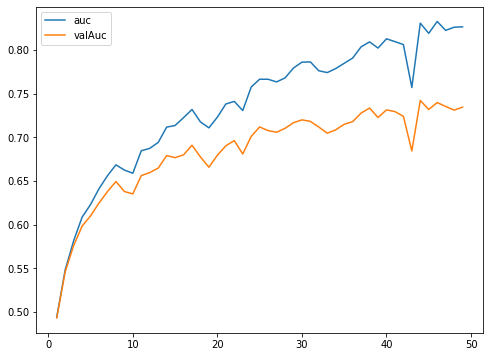

In [41]:
history = pd.DataFrame(history)
print(history.valAuc.max())
history.loc[1:, ["auc", "valAuc"]].plot(figsize=(8,6))
plt.show()

<keras.callbacks.callbacks.History object at 0x7fc90bd8cc88> []
<keras.callbacks.callbacks.History object at 0x7fc90bfde748> []
<keras.callbacks.callbacks.History object at 0x7fc90c83bf28> []
<keras.callbacks.callbacks.History object at 0x7fc90c80d828> []
<keras.callbacks.callbacks.History object at 0x7fc90c80d940> []
<keras.callbacks.callbacks.History object at 0x7fc90c80da58> []
<keras.callbacks.callbacks.History object at 0x7fc90c80db70> []
<keras.callbacks.callbacks.History object at 0x7fc90c80dc88> []
<keras.callbacks.callbacks.History object at 0x7fc90c80dda0> []
<keras.callbacks.callbacks.History object at 0x7fc90c80deb8> []
<keras.callbacks.callbacks.History object at 0x7fc90c80df60> []
<keras.callbacks.callbacks.History object at 0x7fc90bba60b8> []
<keras.callbacks.callbacks.History object at 0x7fc90bba6240> []
<keras.callbacks.callbacks.History object at 0x7fc90bba6358> []
<keras.callbacks.callbacks.History object at 0x7fc90bba6470> []
<keras.callbacks.callbacks.History objec

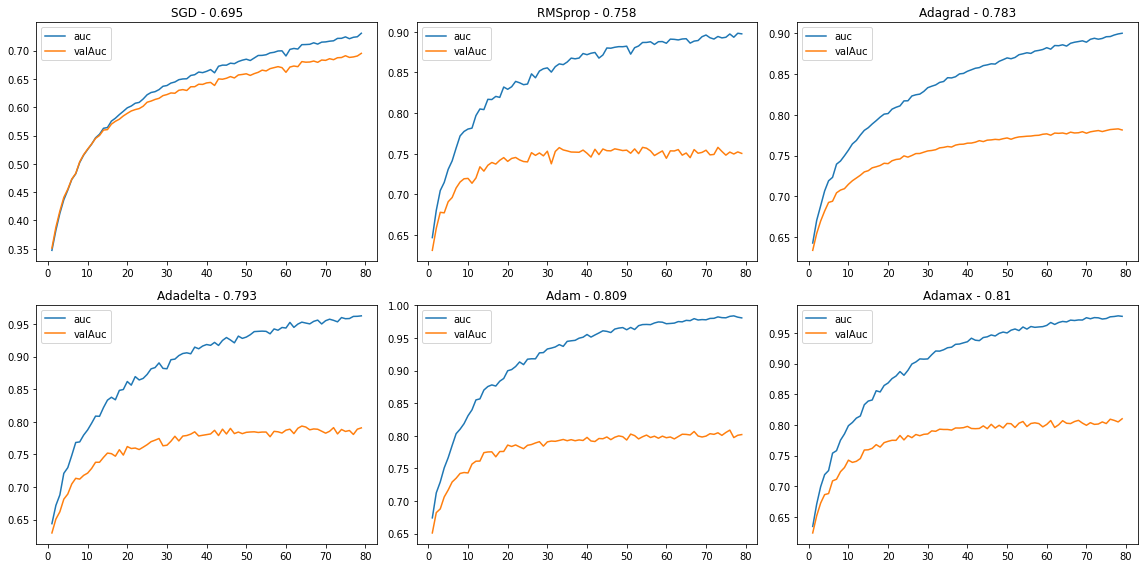

In [42]:
opti = ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]
test_size=0.2
X_train, X_valid = train_test_split(df, test_size=test_size, random_state=2020, stratify=df[target].values)
fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

n = 3
nu1 = 89
nu2 = 336
nu3 = 55

for i, opt in enumerate(opti):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 80, batchSize=200, optimizer=opt, dropout_rate=0.1, dropout_all_layers=False, regu=0, debug=False)
    print(opt, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(opt+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig(f"imgNets/opti_{n}_{nu1}_{nu2}_{nu3}.png")
plt.show()

<keras.callbacks.callbacks.History object at 0x7fc90bb9dc18> []
<keras.callbacks.callbacks.History object at 0x7fc90cd82978> []
<keras.callbacks.callbacks.History object at 0x7fc90db8f518> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc84e0> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc85f8> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8710> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8828> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8940> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8a58> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8b70> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8c88> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8da0> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8eb8> []
<keras.callbacks.callbacks.History object at 0x7fc90dbc8f60> []
<keras.callbacks.callbacks.History object at 0x7fc90d8770b8> []
<keras.callbacks.callbacks.History objec

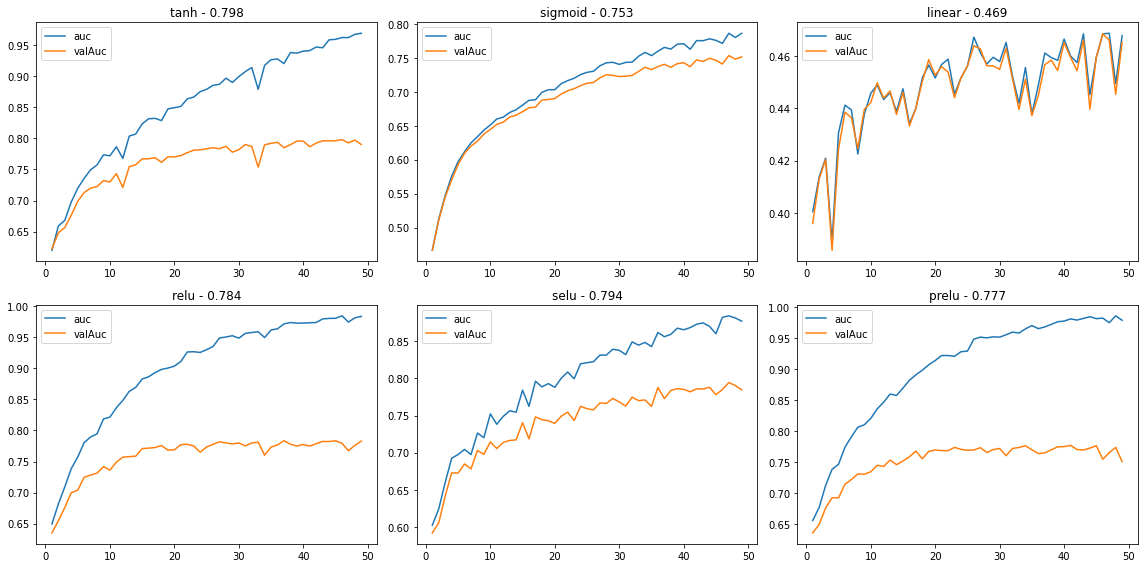

In [43]:
activations = ["tanh", "sigmoid", "linear", "relu", "selu", "prelu"]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax = ax.flatten()

n = 3
nu1 = 89
nu2 = 336
nu3 = 55
for i, acti in enumerate(activations):
    score, bestTrainProba, bestTestProba, history = net(X_train, X_valid, features, target, n=n, nu1=nu1, nu2=nu2, nu3=nu3,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation=acti, debug=False)
    print(acti, score)
    history = pd.DataFrame(history)
    history.loc[1:, ["auc", "valAuc"]].plot(ax = ax[i])
    ax[i].set_title(str(acti)+ " - " + str(round(score, 3)))
    gc.collect()

plt.tight_layout()
fig.savefig(f"imgNets/activations_{n}_{nu1}_{nu2}_{nu3}.png")
plt.show()

In [0]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score


def CVTestNN(nFolds = 5, randomState=2020, features=features, debug=False, *args, **kwargs):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    testResults = []
    trainResults = []
    
    predictions = []
    
    indices = []
    
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        score, trainPred, testPred, history = net(df.iloc[train], df.iloc[test], features, target,
                                                            debug=False, *args, **kwargs)

        predictions.append(testPred.copy())
        
        indices.append(df.iloc[test].index.tolist().copy())
        
        trainScore = average_precision_score(df[target].iloc[train], trainPred)
        testScore = average_precision_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        
        hists.append(history)
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices, hists

In [0]:
trainResults, testResults, predictions, indices, hists = CVTestNN(features=features, n=2, nu1=100, nu2=40, nu3=10,
                                    epochs = 50, batchSize=200, optimizer="Adam", activation="prelu",
                                     dropout_rate=0.2, dropout_all_layers=False, regu=0.025, debug=False)
print(np.mean(testResults))

modelNN = {
    "name":"NNet",
    "description":"Model NN",
    "specification":'features=features, n=2, nu1=100, nu2=40, nu3=10, epochs = 50, batchSize=200, optimizer="Adam", activation="prelu", dropout_rate=0.2, dropout_all_layers=False, regu=0.025, debug=False',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [0]:
import pickle
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_NN_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelNN, fp)

In [0]:
opts[]
acts=[]

In [0]:
import random
from numpy import random
opts=['Adamax', 'Adam', 'SGD']
acts=['prelu', 'relu', 'selu']
btch=[100,200,300]
inne=[0,0.2,0.4,0.6,0.8]
wielkosc=[2,3]
results=[]
paramList = []
par=[]
wyn=[]
for x in range(500):
    params = (random.choice(wielkosc), random.randint(30,100), random.randint(300,500), random.randint(10,60), random.choice(opts), random.choice(acts), random.randint(30,60),random.choice(btch), random.choice(inne),random.choice(inne))
    trainResults, testResults, predictions, indices, hists = CVTestNN(
        n=params[0],
        nu1 = params[1],
        nu2 = params[2],
        nu3 = params[3],
        optimizer=params[4],
        activation=params[5],
        echos=params[6],
        batchsize=params[7],
        dropout_rate=params[8],
        dropout_all_layers=False,
        regu=params[9])
    print(np.mean(testResults), params)
    par.append(params)
    wyn.append(testResults)
    results.append(np.mean(testResults))
    paramList.append(params)
    mmm={
    'wyniki': wyn,
     'parm': parm}

    with open("/content/drive/My Drive/modele/dane.p", "wb") as fp:
      pickle.dump(mmm, fp)


<keras.callbacks.callbacks.History object at 0x7f991722ae48> []
<keras.callbacks.callbacks.History object at 0x7f99126ef7f0> []
<keras.callbacks.callbacks.History object at 0x7f9911b60550> []
<keras.callbacks.callbacks.History object at 0x7f9911b692e8> []
<keras.callbacks.callbacks.History object at 0x7f9911b69400> []
<keras.callbacks.callbacks.History object at 0x7f9911b69518> []
<keras.callbacks.callbacks.History object at 0x7f9911b69630> []
<keras.callbacks.callbacks.History object at 0x7f9911b69748> []
<keras.callbacks.callbacks.History object at 0x7f9911b69860> []
<keras.callbacks.callbacks.History object at 0x7f9911b69978> []
<keras.callbacks.callbacks.History object at 0x7f9911b69a90> []
<keras.callbacks.callbacks.History object at 0x7f9911b69ba8> []
<keras.callbacks.callbacks.History object at 0x7f9911b69cc0> []
<keras.callbacks.callbacks.History object at 0x7f9911b69dd8> []
<keras.callbacks.callbacks.History object at 0x7f9911b69ef0> []
<keras.callbacks.callbacks.History objec

In [0]:
import pickle

In [45]:
trainResults, testResults, predictions, indices, hists = CVTestNN(features=features, n=3, nu1=89, nu2=336, nu3=55,
                                    epochs = 50, batchSize=200, optimizer="Adam", activation="selu",
                                     dropout_rate=0.1, dropout_all_layers=False, regu=0, debug=False)
print(np.mean(testResults))

modelNN = {
    "name":"NNet",
    "description":"Model NN",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

<keras.callbacks.callbacks.History object at 0x7fc90c067fd0> []
<keras.callbacks.callbacks.History object at 0x7fc90b4d49e8> []
<keras.callbacks.callbacks.History object at 0x7fc906683550> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a518> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a5c0> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a748> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a860> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a978> []
<keras.callbacks.callbacks.History object at 0x7fc90c43aa90> []
<keras.callbacks.callbacks.History object at 0x7fc90c43aba8> []
<keras.callbacks.callbacks.History object at 0x7fc90c43acc0> []
<keras.callbacks.callbacks.History object at 0x7fc90c43add8> []
<keras.callbacks.callbacks.History object at 0x7fc90c43aef0> []
<keras.callbacks.callbacks.History object at 0x7fc90c43a630> []
<keras.callbacks.callbacks.History object at 0x7fc90bc80160> []
<keras.callbacks.callbacks.History objec

In [0]:
import pickle
with open("model_NN_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelNN, fp)

In [44]:
trainResults, testResults, predictions, indices, hists = CVTestNN(features=features, n=3, nu1=89, nu2=336, nu3=55,
                                    epochs = 50, batchSize=200, optimizer="Adamax", activation="selu",
                                     dropout_rate=0.1, dropout_all_layers=False, regu=0, debug=False)
print(np.mean(testResults))

modelNN = {
    "name":"NNet",
    "description":"Model NN",
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

<keras.callbacks.callbacks.History object at 0x7fc90c34a0f0> []
<keras.callbacks.callbacks.History object at 0x7fc90c7eae10> []
<keras.callbacks.callbacks.History object at 0x7fc90c7cd198> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f47b8> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f48d0> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f49e8> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4b00> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4c18> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4d30> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4e48> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4f60> []
<keras.callbacks.callbacks.History object at 0x7fc90c7f4ef0> []
<keras.callbacks.callbacks.History object at 0x7fc90b7091d0> []
<keras.callbacks.callbacks.History object at 0x7fc90b7092e8> []
<keras.callbacks.callbacks.History object at 0x7fc90b709400> []
<keras.callbacks.callbacks.History objec

In [0]:
from sklearn.metrics import precision_recall_curve
def plotAP(results):

	fig, ax = plt.subplots(figsize=(10,9))

	for true, pred, label in results:
		precision, recall, thresholds = precision_recall_curve(true, pred)
		average_precision = average_precision_score(true, pred)
		average_precision = round(average_precision, 4)
		lw=2
		ax.plot(recall, precision, lw=lw, label=f'{label}: {average_precision}')
  
	ax.set_xlim([0, 1])
	ax.set_ylim([0.0, 1.01])
	ax.set_xlabel('Recall')
	ax.set_ylabel('Precision')
	ax.set_title(f'Precision Recall Curve ')
	ax.legend(loc="lower right")
	plt.show()

In [0]:
with open("/content/drive/My Drive/modele/model_NN_1.p", "rb") as fp:
    modelNN = pickle.load(fp)
with open("/content/drive/My Drive/modele/model_XGB_1.p", "rb") as fp:
    modelXGB = pickle.load(fp)
with open("/content/drive/My Drive/modele/model_RF_1.p", "rb") as fp:
    modelRF = pickle.load(fp)

In [0]:
for k in ["SGD", "RMSprop", "Adagrad", "Adadelta", "Adam", "Adamax"]:
  trainResults, testResults, predictions, indices, hists = CVTestNN(features=features, n=3, nu1=89, nu2=336, nu3=55,
                                    epochs = 50, batchSize=200, optimizer=k, activation="selu",
                                     dropout_rate=0.5, dropout_all_layers=False, regu=0, debug=False)
  print(np.mean(testResults))



<keras.callbacks.callbacks.History object at 0x7f9b9c7bd160> []
<keras.callbacks.callbacks.History object at 0x7f9b9c0760f0> []
<keras.callbacks.callbacks.History object at 0x7f9b9c0760b8> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4208> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4320> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4438> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4550> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4668> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4780> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4898> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced49b0> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4ac8> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4be0> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4cf8> []
<keras.callbacks.callbacks.History object at 0x7f9b9ced4e10> []
<keras.callbacks.callbacks.History objec